In [1]:
from helper import *
import numpy as np, matplotlib.pyplot as plt
import cv2
from PIL import Image
import glob
import piexif
from PIL.ExifTags import TAGS
from scipy.optimize import curve_fit

%matplotlib inline

### Data loading and exploration

In [2]:
def load_jpg_sequence(folder):
    """Takes a folder as input and returns the images and exposure times in
    the folder."""
    files = sorted(glob.glob(folder + "/*.jpg"))
    images = []
    exposure_times = []

    for f in files:
        img = cv2.imread(f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

        # read exposure time from EXIF
        exif_dict = piexif.load(f)
        num, den = exif_dict["Exif"][piexif.ExifIFD.ExposureTime]
        exposure_times.append(num / den)

    return images, exposure_times

def calculate_pixel_mean(im):
    """ Calcuate the pixel mean of the entire image """   
    return np.mean(im.astype(np.float32))

Loaded 12 images with exposure times: [13.0, 6.0, 3.2, 1.6, 0.8, 0.4, 0.2, 0.1, 0.05, 0.025, 0.0125, 0.00625]


Text(0.5, 1.0, 'Mean Pixel Value vs Exposure Time')

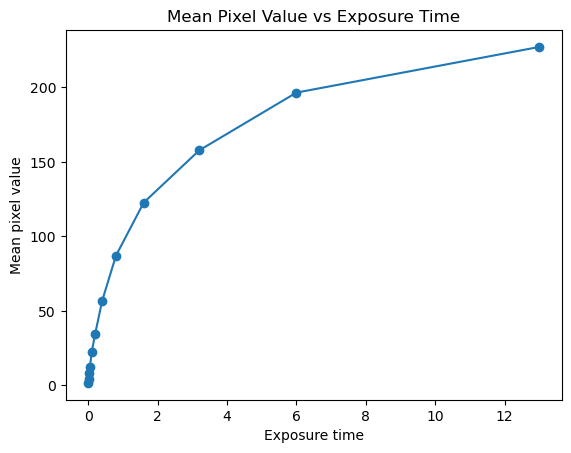

In [3]:
images, exp_times = load_jpg_sequence("hdr-jpg")
print(f"Loaded {len(images)} images with exposure times: {exp_times}")

means = [calculate_pixel_mean(image) for image in images]
means = np.array(means, dtype=np.float32)
exp_times = np.array(exp_times, dtype=np.float32)

# plot to check nonlinearity
plt.plot(exp_times, means, 'o-')
plt.xlabel("Exposure time")
plt.ylabel("Mean pixel value")
plt.title("Mean Pixel Value vs Exposure Time")

So the data is non-linear

We need to find the function that produces this curve, i.e. how this non linearity is achieved

In [4]:
 # normalize to [0,1]
means = means / 255.0 

#  y = c * x1^gamma
def objective(x1, c, gamma):
    return c * np.power(x1, gamma)

# initial values
ini = (.1, .1)

# fit
params, cov = curve_fit(objective, exp_times, means, p0=ini)
c_est, gamma_est = params

print("Estimated gamma:", gamma_est)
print("Estimated c:", c_est)

Estimated gamma: 0.4039780863641747
Estimated c: 0.34545074710060086


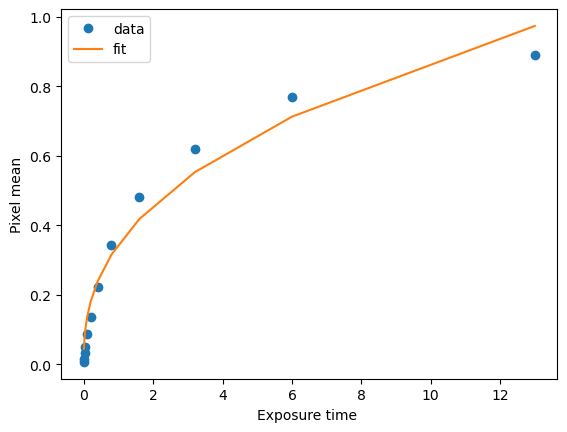

In [5]:
# plot data and fit
m_fit = objective(exp_times, c_est, gamma_est)
plt.plot(exp_times, means, 'o', label='data')
plt.plot(exp_times, m_fit, '-', label='fit')
plt.xlabel("Exposure time ")
plt.ylabel("Pixel mean")
plt.legend()

Let the function be $y = c * x^\gamma$ where, $c= 0.34545074710060086$ and $\gamma = 0.4039780863641747$. We now derive the inverse of the function to scale back the original linear pixel values

In [6]:
def inverse_curve(y, c, gamma):
    """ Inverse of the fitted curve to linearize pixel values """
    return np.power((y / c), (1 / gamma))

def linearize_image(img, c, gamma):
    img = img.astype(np.float32) / 255.0  # normalize to [0,1]
    img_linearized = inverse_curve(img, c, gamma)
    return img_linearized

# Linearize all images
linearized_images = [linearize_image(img, c_est, gamma_est) for img in images]

In [7]:
# Combine linearized images with their exposure times
data = list(zip(linearized_images, exp_times))

#### HDR on linearized data

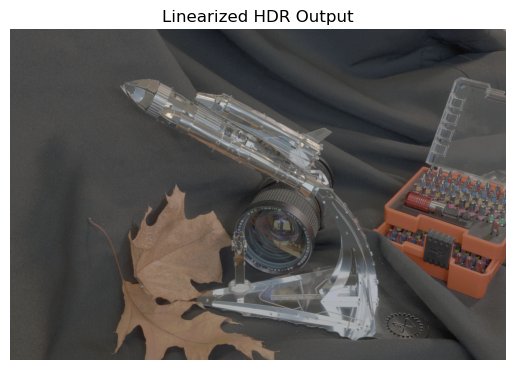

In [14]:
hdr_im = HDR(data)
# log norm
log_norm_image = log_norm(hdr_im)

# Visualize the images
visualize_image(log_norm_image, title="Linearized HDR Output")